## **Welcome to the Real Estate Price Prediction Project ⛪ !**

This document serves as a guide for the team members involved in developing a model to predict real estate prices across different regions in Morocco. The project will consider various factors such as location, amenities, and economic trends. Here, we'll break down the workflow into different sections to facilitate collaboration and understanding.

**Section 1: Data Scraping**🕵️‍♂️
- Use appropriate web scraping tools or APIs to collect real estate listings, economic indicators, and other relevant data.
- Save the raw data here https://docs.google.com/spreadsheets/d/1kPbv0ZIZdOyt_nOMSS6xup9B4LDuHYDnXEgEvqEZ1ko/edit?usp=sharing
for further analysis.


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urlparse, urljoin

baseurl = 'https://www.mu.ma/'
product_links = set()  # Use a set to store unique links

for x in range(1, 3):
    r = requests.get(f'https://www.mu.ma/fr/sc/appartements-a-vendre:p:{x}')
    soup = BeautifulSoup(r.content, 'html.parser')
    data = soup.find_all(class_='listingBox w100')

    for listing in data:
        links = listing.find_all('a', href=True)
        for link in links:
            productlink = link['href']
            # Check if the URL is valid
            if not urlparse(productlink).scheme:
                productlink = urljoin(baseurl, productlink)
            product_links.add(productlink)  # Add link to the set

prdctlist = []
for link in product_links:
    try:
        # Check if the URL is valid
        if urlparse(link).scheme:
            r = requests.get(link)
            soup = BeautifulSoup(r.content)

            name_element = soup.find('h1', class_='searchTitle')
            if name_element:
                name = name_element.text.strip()
            else:
                print('Name not found on page:', link)
                continue

            price_element = soup.find('h3', class_='orangeTit')
            price = price_element.text.strip() if price_element else None

            secteur_element = soup.find('h3', class_='greyTit')
            secteur = secteur_element.text.replace('\n', '').replace('\t', '').strip() if secteur_element else None

            cat_nav_div = soup.find('div', class_='catNav')
            elements = cat_nav_div.find_all('span', class_='tagProp')

            # Assign values to variables
            surface = elements[0].text.replace('\n', '').replace('\t', '').strip() if elements and len(elements) > 0 else None
            pieces = elements[1].text.replace('\n', '').replace('\t', '').strip() if elements and len(elements) > 1 else None
            chambres = elements[2].text.replace('\n', '').replace('\t', '').strip() if elements and len(elements) > 2 else None
            sdb = elements[3].text.replace('\n', '').replace('\t', '').strip() if elements and len(elements) > 3 else None
            etat = elements[4].text.replace('\n', '').replace('\t', '').strip() if elements and len(elements) > 4 else None
            age = elements[5].text.replace('\n', '').replace('\t', '').strip() if elements and len(elements) > 5 else None
            etage = elements[6].text.replace('\n', '').replace('\t', '').strip() if elements and len(elements) > 6 else None

        else:
            print('Invalid URL:', link)
            continue

    except Exception as e:
        print('Error processing page:', link)
        print(e)
        continue

    mydata = {
        'name': name,
        'price': price,
        'secteur': secteur,
        'surface': surface,
        'pieces': pieces,
        'chambres': chambres,
        'sdb': sdb,
        'etat': etat,
        'age': age,
        'etage': etage
    }
    prdctlist.append(mydata)
    print('Saving', mydata['name'])

df = pd.DataFrame(prdctlist)
df.to_excel('scraped_data.xlsx', index=False)
print(df.head(15))



Empty DataFrame
Columns: []
Index: []


**Section 2: Data Cleaning 🧹**
   - Remove duplicates, missing values, and irrelevant columns. Standardize data types for consistency.
   - Identify outliers and decide whether they stay on the dance floor or get escorted out gracefully.
   - Create new features or transform existing ones to make our data dazzle on the dance floor.
   -Save the clean data here https://docs.google.com/spreadsheets/d/1iATaX4pNokkCmg2GQmzc-pZ9mrn-GZTfRK2sMd9rXzs/edit?usp=sharing

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.preprocessing import StandardScaler

#After some Cleaning with VBA Macros of https://docs.google.com/spreadsheets/u/1/d/1kPbv0ZIZdOyt_nOMSS6xup9B4LDuHYDnXEgEvqEZ1ko/edit?usp=sharing for Scraped Moroccan Real Estate Price Dataset

# Upload the Excel file
uploaded = files.upload()

# Read the Excel file into a DataFrame
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Drop duplicate rows
df = df.drop_duplicates()

# Drop rows without a price
df = df.dropna(subset=['price'])

# Fill missing values in 'city' with corresponding values from 'secteur'
df['city'] = df['city'].fillna(df['secteur'])

# Fill missing values in 'sdb' and 'chambres' with the mean
mean_sdb = df['sdb'].mean()
mean_chambres = df['chambres'].mean()
mean_surface = df['surface'].mean()
df['sdb'].fillna(mean_sdb, inplace=True)
df['chambres'].fillna(mean_chambres, inplace=True)
df['surface'].fillna(mean_surface, inplace=True)

# Fill missing values in 'pieces' with the sum of 'sdb' and 'chambres'
df['pieces'] = df['pieces'].fillna(df['sdb'] + df['chambres'])

# One-hot encode 'secteur' and 'city' columns
df = pd.get_dummies(df, columns=['secteur', 'city'])

# Display the updated DataFrame
print(df)

# Count non-missing values in each column
non_missing_counts = df.count()
print("\nNon-Missing Value Counts:")
print(non_missing_counts)

# Save the cleaned DataFrame to an Excel file
cleaned_file_name = 'cleaned_dataset.xlsx'
df.to_excel(cleaned_file_name, index=False)

Saving Moroccan Real Estate Price Clean Dataset  (1).xlsx to Moroccan Real Estate Price Clean Dataset  (1).xlsx
                                                    name    price  surface  \
0      Appartement de 65m² en vente, Complexe Résiden...   250000     65.0   
1           Vente appartement à quartier geliz marrakech   135000    104.0   
2        Av grand appartement terrasse mohammedia centre  2300000    169.0   
3      Appartement à vendre 269 m², 3 chambres Val Fl...  3800000    269.0   
4              Appartement de 105 m² en vente, Rio Beach     9900    105.0   
...                                                  ...      ...      ...   
13563  BEAU REZ DE JARDIN à vendre avec 60 m2 de JARD...  3900000    278.0   
13564   Bel appartement à vendre à Casablanca Val Fleuri  1390000    107.0   
13565  Appartement à l'achat à Sidi Moumen. 3 grandes...   800000    100.0   
13566  Superbe appartement à vendre à Sakani. 3 grand...   370000     60.0   
13567  Superbe appartement à v

**Section 3: Exploratory Data Analysis (EDA) 📊**

This section provides a comprehensive analysis of the real estate dataset. It begins with an overview of price distribution, followed by visualizations such as histograms and boxplots to understand the distribution of prices and relationships between variables. Temporal trends, outliers, and feature engineering are addressed. Furthermore, geospatial visualization techniques are applied to plot properties on an interactive map. Finally, a comparison of prices across regions sheds light on regional disparities.


In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import folium
from geopy.geocoders import Nominatim
import time

# Load cleaned data (https://docs.google.com/spreadsheets/d/1iATaX4pNokkCmg2GQmzc-pZ9mrn-GZTfRK2sMd9rXzs/edit#gid=1009096573)
uploaded = files.upload()

# Read the Excel file into a DataFrame
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Initialize geocoder
geolocator = Nominatim(user_agent="my_geocoder")

# Function to get coordinates for a location with retries
def get_coordinates_with_retry(location, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.geocode(location)
            if location:
                return location.latitude, location.longitude
            else:
                return None, None
        except Exception as e:
            print(f"Error occurred: {e}. Retrying...")
            retries += 1
            time.sleep(1)  # Wait for 1 second before retrying
    print("Max retries exceeded. Could not obtain coordinates.")
    return None, None


In [ ]:
# Choose a location-related column ('secteur' or 'city')
location_column = 'secteur'  # Adjust this based on your dataset

# Add latitude and longitude columns to DataFrame with retries
df['latitude'], df['longitude'] = zip(*df[location_column].apply(get_coordinates_with_retry))

# Filter out rows with missing coordinates
df = df.dropna(subset=['latitude', 'longitude'])

# Create map centered around Morocco
m = folium.Map(location=[31.7917, -7.0926], zoom_start=6)

# Define a function to choose marker color based on some property (e.g., price)
def choose_marker_color(price):
    # Define your logic here to choose color based on price or any other property
    if price < 200000:  # Example condition
        return 'green'
    elif price < 1000000:  # Example condition
        return 'blue'
    else:
        return 'red'

# Plot each property as a marker on the map with a custom marker color
for index, row in df.iterrows():
    marker_color = choose_marker_color(row['price'])  # Adjust this based on your property
    folium.Marker([row['latitude'], row['longitude']], popup=row['name'], icon=folium.Icon(color=marker_color)).add_to(m)

# Save the map as an HTML file
m.save('real_estate_properties_map.html')


# Overview
print(df['price'].describe())

# Distribution of Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Real Estate Prices')
plt.xlabel('Price (Currency)')
plt.ylabel('Frequency')
plt.show()

# Categorical Features Analysis
plt.figure(figsize=(14, 8))
sns.boxplot(x='surface', y='price', data=df, palette='viridis')
plt.title('Property Condition vs. Price')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.show()

# Numerical Features Analysis
sns.pairplot(df[['price', 'surface', 'pieces', 'sdb', 'chambres']])
plt.show()

# Plot prices over time

# Price Distribution by Currency
plt.figure(figsize=(12, 8))
sns.boxplot(x='pieces', y='price', data=df, palette='muted')
plt.title('Price Distribution by Currency')
plt.xlabel('Currency')
plt.ylabel('Price')
plt.show()

# Outliers Detection
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))

# Feature Engineering
df['Price_per_sqm'] = df['price'] / df['surface']

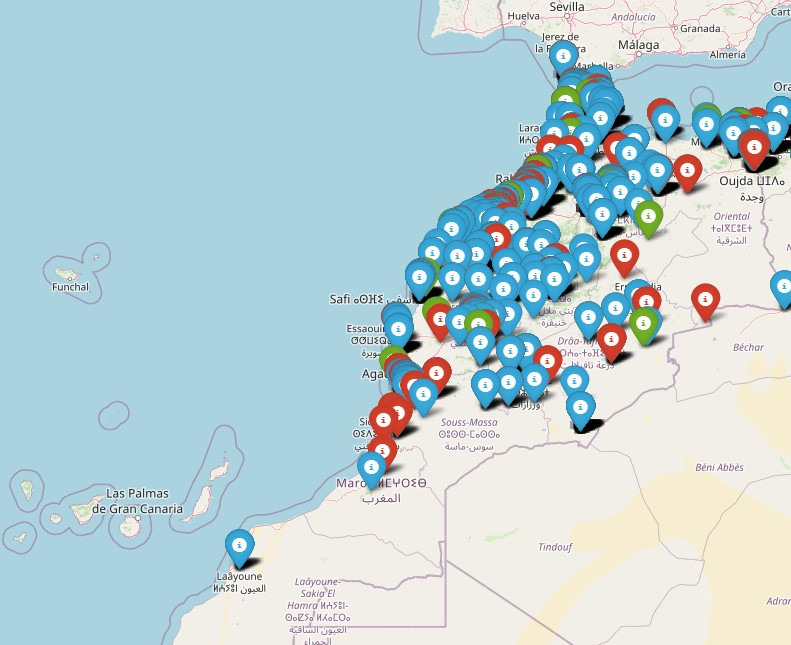


'green' for price < 200,000, 'blue' for 200,000 <= price < 1,000,000, and 'red' for price >= 1,000,000


In [ ]:
from IPython.display import display, Image

# Specify the path to your image file
img_path = '/content/img_map.jpg'

# Display the image
img = Image(filename=img_path)
display(img)
print("\n'green' for price < 200,000, 'blue' for 200,000 <= price < 1,000,000, and 'red' for price >= 1,000,000")

**Section 4: Model Development 🤖**
- Normalize and standardize – our models are preparing for a synchronized dance.
- Choose your dance partners – regression models that groove with our data vibes.
- Split the dance floor into training and validation sets.
- Train our models like dance instructors – elegant, yet powerful.
- Rate the dance performance – our models should leave everyone in awe.


In [ ]:
!pip install tensorflow
from google.colab import files
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load cleaned data (https://docs.google.com/spreadsheets/d/1iATaX4pNokkCmg2GQmzc-pZ9mrn-GZTfRK2sMd9rXzs/edit#gid=1009096573)
uploaded = files.upload()

# Read the Excel file into a DataFrame
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

# Check for missing values
print("Number of missing values in each column:")
print(df.isnull().sum())


# Suppression des valeurs manquantes
df.dropna(inplace=True)

# Encodage one-hot des colonnes 'secteur' et 'city'
df = pd.get_dummies(df, columns=['secteur', 'city'])

# Définition des features et de la variable cible
excluded_features = ['name', 'price']
X = df.drop(columns=excluded_features).values
y = df['price'].values

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Définition du modèle avec régularisation
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compilation du modèle avec une fonction de perte différente
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

# Mise en place de l'arrêt anticipé
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Évaluation du modèle
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# Prédictions
y_pred = model.predict(X_test_scaled)

# Calcul de métriques supplémentaires
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Sauvegarde du modèle au format Keras native

model.save('real_estate_price_prediction_model.h5')



Saving Moroccan Real Estate Price Clean Dataset .xlsx to Moroccan Real Estate Price Clean Dataset .xlsx
Number of missing values in each column:
name               0
price              0
secteur            1
city               0
surface            1
pieces             0
chambres          51
sdb               70
age                2
etage              0
etat_Bon état      0
etat_Nouveau       0
etat_À rénover     0
dtype: int64
Epoch 1/100
270/270 [==============================] - 3s 5ms/step - loss: 1648189.6250 - mae: 1648161.8750 - val_loss: 1892152.2500 - val_mae: 1892053.2500
Epoch 2/100
270/270 [==============================] - 1s 4ms/step - loss: 1635805.8750 - mae: 1635537.6250 - val_loss: 1866385.5000 - val_mae: 1865901.8750
Epoch 3/100
270/270 [==============================] - 1s 4ms/step - loss: 1590252.5000 - mae: 1589466.0000 - val_loss: 1797645.1250 - val_mae: 1796509.1250
Epoch 4/100
270/270 [==============================] - 1s 4ms/step - loss: 1496861.7500 - mae: 149

**Section 5: Deployment 🚢**
- Discuss deployment options – our models are ready to hit the global stage!

In [ ]:
#Here is a mini deployment ^^
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load the trained model
model = tf.keras.models.load_model('real_estate_price_prediction_model.h5')

# Load the original dataset to get unique categories for 'secteur' and 'city'
original_df = pd.read_excel('Moroccan Real Estate Price Clean Dataset Final.xlsx')

# Get unique categories for 'secteur' and 'city'
unique_secteurs = original_df['secteur'].unique()
unique_cities = original_df['city'].unique()

# Define the column names
columns = ['surface', 'pieces', 'chambres', 'sdb', 'age', 'etage', 'etat_Bon état', 'etat_Nouveau', 'etat_À rénover', 'secteur', 'city']

# Function to preprocess user input
def preprocess_input(user_input, columns, unique_secteurs, unique_cities):
    # Define the total number of features expected by the model
    total_features = 1015

    # Initialize all features to 0
    input_array = np.zeros((1, total_features), dtype=np.float64)

    # Update numerical features
    numerical_features = ['surface', 'pieces', 'chambres', 'sdb', 'age', 'etage', 'etat_Bon état', 'etat_À rénover']
    for feature in numerical_features:
        input_array[0, columns.index(feature)] = user_input[feature]

    # Update categorical features
    for feature in ['secteur', 'city']:
        if user_input[feature] in unique_secteurs or user_input[feature] in unique_cities:
            input_array[0, columns.index(user_input[feature])] = 1

    return input_array

# Function to predict price based on user input
def predict_price(user_input):
    # Preprocess the user input
    input_array = preprocess_input(user_input, columns, unique_secteurs, unique_cities)

    # Make prediction using the model
    predicted_price = model.predict(input_array)

    return predicted_price[0][0]

# Ask user to input feature values
user_input = {}
for column in columns:
    if column in ['secteur', 'city']:
        user_input[column] = input(f"Enter value for '{column}': ")
    else:
        user_input[column] = float(input(f"Enter value for '{column}': "))

# Predict price based on user input
predicted_price = predict_price(user_input)

# Display the predicted price
print(f"\nPredicted price: {predicted_price}")


Enter value for 'surface': 50
Enter value for 'pieces': 4
Enter value for 'chambres': 3
Enter value for 'sdb': 1
Enter value for 'age': 6
Enter value for 'etage': 1
Enter value for 'etat_Bon état': 1
Enter value for 'etat_Nouveau': 0
Enter value for 'etat_À rénover': 0
Enter value for 'secteur': 'Bouskoura'
Enter value for 'city': 'Bouskoura'
1/1 [==============================] - 0s 84ms/step

Predicted price: 23080328.0


link to our GUI where we deployed our model ^^:
 https://huggingface.co/spaces/saaara/real_estate_price_prediction

 made with ❤